## The Numerov Method for Solving the Schr&ouml;dinger Equation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/akanotoe/QM/HEAD) [![nbviewer](https://img.shields.io/badge/view%20in-nbviewer-orange)](https://nbviewer.jupyter.org/github/akanotoe/QM/blob/main/GeneralNumerov.ipynb)

The [Numerov method][numerov] is used to solve differential equations of the form

$$\frac{d^2 y}{dx^2} = - g(x) y(x) + s(x)$$

In the case of the 1D time-independent Schr&ouml;dinger equation for a quantum object of mass $m$ with energy $E$ subjected to a potential $V(x)$, we have (upon rearranging)

$$\frac{d^2 \psi}{dx^2} = -\frac{2m(E-V(x))}{\hbar^2}\psi,$$

where $\psi(x)$ is the wave function of the quantum object. From this point, we need to find natural units with which to nondimensionalize the differential equation. The natural units typically depend on the specific problem. In atomic/molecular physics, it is common to use [atomic units][au] based on the properties of the hydrogen atom. For other general problems, the natural units are found in the Schr&ouml;dinger equation itself.

Take, for instance, the simple harmonic oscillator (classical problem of the mass on a spring). The potential energy takes the form 

$$V(x) = \frac{1}{2} kx^2 = \frac{1}{2} m\omega^2 x^2,$$

where $k$ is the spring constant and $\omega$ is the natural (angular) frequency of oscillation. The natural units for this system are derived from factors of $m$, $\omega$, and $\hbar$. For instance, the natural energy unit is $\hbar\omega$, while the natural unit of distance is $\sqrt{\hbar/m\omega}$. Thus, we define the dimensionless distance $\xi = x\sqrt{m\omega/\hbar}$, and our rearranged Schr&ouml;dinger equation becomes

$$\frac{d^2 \psi}{d\xi^2} = -\frac{2(E-V(\xi))}{\hbar\omega}\psi.$$

[numerov]: https://en.wikipedia.org/wiki/Numerov%27s_method "wiki:Numerov's method"
[au]: https://en.wikipedia.org/wiki/Hartree_atomic_units "wiki:Hartree atomic units"

Since $\psi$ is dimensionless due to the change of independent variable, it should be evident now that this equation is dimensionless. Comparing our dimensionless Schr&ouml;dinger equation with the first differential equation, we can identify
* $x \to \xi$
* $y \to \psi$
* $g(x) \to 2(E-V(\xi))/\hbar\omega$


Computationally, the Numerov method relates these quantities to each other in the following way:

$$
\begin{align}
\psi_{n+1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2 (E-V_{n+1})}{\hbar\omega} \right) 
&= 2 \psi_n \left(1 - \frac{5 (\Delta \xi)^2}{12} \frac{2(E-V_{n})}{\hbar\omega} \right)\\ 
&\!\quad - \psi_{n-1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2(E-V_{n-1})}{\hbar\omega} \right) \\
&\!\quad + \mathcal{O} \left((\Delta \xi)^6 \right).
\end{align}
$$

We can also write this in matrix notation as (Pillai, Goglio, and Walker, [*Am. J. Phys.*][AJPNumerov] **80**, 1017 (2012), [PDF][NumerovPDF])

$$A \, \psi = -2B\, \frac{(E-V)}{\hbar\omega}\psi$$

where 

$$A = \frac{1}{(\Delta \xi)^2}
\begin{pmatrix}
-2 & 1 & 0 & 0 & \cdots \\
1 & -2 & 1 & 0 &\cdots \\
0 & 1 & -2 & 1 & \cdots \\
0 & 0 &  1 & -2 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
, \quad
B = \frac{1}{12}
\begin{pmatrix}
10 & 1 & 0 & 0 & \cdots \\
1 & 10 & 1 & 0 &\cdots \\
0 & 1 & 10 & 1 & \cdots \\
0 & 0 &  1 & 10 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix},
$$

$\psi$ is treated as a column vector, and $V$ is a diagonal matrix. We can rearrange this to get an eigenvalue equation,

$$\left(-\frac{1}{2} B^{-1}A + \frac{V}{\hbar\omega}\right)\psi = \frac{E}{\hbar\omega}\psi,$$

where we can see that

$$H = -\frac{1}{2} B^{-1}A + \frac{V}{\hbar\omega}$$

is the Hamiltonian in the Numerov representation. Finding the eigenvalues of this matrix will yield the energies of the system.

[AJPNumerov]: http://dx.doi.org/10.1119/1.4748813 "AJP Numerov paper"
[NumerovPDF]: https://pages.physics.wisc.edu/~tgwalker/106.Numerov.pdf "Numerov Paper PDF"

Here I'm going to attempt to write code to run the Numerov method on arbitrary potential functions. Our first step is to import the necessary packages we will need.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import scipy.special as sp
import matplotlib.pyplot as plt
%matplotlib inline

Next, we need to construct the arrays for our potential energy function, its domain, and the A and B matrices that arise from both.

In [2]:
xmax = 10
npts = 2**11
x = np.linspace(-xmax, xmax, num=npts, endpoint=True)
dx = (2*xmax)/(npts-1)
# Construct the potential
# SHO
Vx = 0.5*x**2
# Abs value
# Vx = abs(x)

# Construct A and B matrices
A = dx**(-2)*(np.diag(np.ones(len(x)-1), -1) - 2.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))
B = 1./12*(np.diag(np.ones(len(x)-1), -1) + 10.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))

# Construct V matrix
V = np.diag(Vx)

This next part is quite computationally intensive. Here we invert $B$ and get the eigenvalues $E$ and eigenvectors $\psi$ of $H$.

In [3]:
# Take inverse of B
Binv = np.linalg.inv(B)
Hmat = -0.5 * np.dot(Binv, A) + V
# Hmat = -np.dot(Binv, A) + V
# Get eigenvalues and eigenvectors (psi) of Hamiltonian.
en, psi = np.linalg.eigh(Hmat)
# Normalize the wave functions
psi = psi/dx**0.5

# r2inv=[]
# for v in range(0,len(en)-1):
#     if en[v] < 0.5*xmax**2:
#        psiint = interp1d(Rint, psi[:,v]*psi[:,v], kind='cubic')
#        norm = sp.integrate.simps(psi[:,v]**2, x)
#        psi[:,v] = psi[:,v]/norm**0.5
#        r2inv.append(sp.integrate.simps(psi[:,v]**2 / x**2, x))

Here the wave functions are plotted over the potential energy well. Note that the at the classical turning points, the wave function has an inflection point beyond which it decays rapidly to zero in the classically forbidden region.

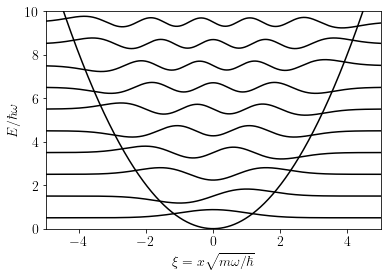

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='14')

plt.figure()
plt.xlim([-xmax/2, xmax/2])
plt.ylim([0, xmax])
plt.xlabel('$\\xi = x\sqrt{m\\omega/\\hbar}$')
# plt.xlabel('$\\xi = z/z_0$')
plt.ylabel('$E/\\hbar\\omega$')
# plt.ylabel('$E/mgz_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, (-1)**(v+1)*0.5*psi[:,v] + en[v], 'k-')
# plt.savefig('AbsWellwvfcns.svg')
# plt.savefig('SHOwvfcns.svg')

This next plot is the potential well with the probability densities $|\psi(x)|^2$ superimposed. The pattern is quite pleasing.

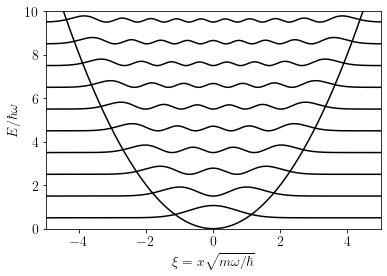

In [5]:
plt.figure()
plt.xlim([-xmax/2, xmax/2])
plt.ylim([0, xmax])
plt.xlabel('$\\xi = x\sqrt{m\\omega/\\hbar}$')
# plt.xlabel('$\\xi = z/z_0$')
plt.ylabel('$E/\\hbar\\omega$')
# plt.ylabel('$E/mgz_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, psi[:,v]*psi[:,v] + en[v], 'k')
# plt.savefig('AbsWellProb.svg')
# plt.savefig('SHOprob.svg')

It's helpful to see how accurately the Numerov method reproduced the known energies of the harmonic oscillator. In the natural units used above, the energy eigenvalues occur at $n+1/2$. This loop finds the percent error,

$$100\% \times \left(\frac{\text{calculated value}}{\text{actual value}} -1 \right),$$

as a comparison. Only at the highest $n$ values does the percent error get close to 1%, and even then it does not cross the 1% threshold.

In [6]:
# This lists the percent error for each energy of the SHO
print('n', '\t', '% error', '\n')
for i in range(int(len(en)/2)):
    if en[i] < max(Vx):
        print(i, '\t', 100*(en[i]-i-.5)/(i+.5))

n 	 % error 

0 	 -7.026257353714982e-09
1 	 -1.6501999766660447e-08
2 	 -3.5545983934071046e-08
3 	 -6.407565272021592e-08
4 	 -1.0205724660434296e-07
5 	 -1.4951921720942415e-07
6 	 -2.064718447496279e-07
7 	 -2.7292075562475776e-07
8 	 -3.4889094489271347e-07
9 	 -4.3430729889630466e-07
10 	 -5.29245777361861e-07
11 	 -6.336659660756476e-07
12 	 -7.476031811393113e-07
13 	 -8.710114835147815e-07
14 	 -1.0039221316329248e-06
15 	 -1.146325712489494e-06
16 	 -1.2982307807898465e-06
17 	 -1.4596271163164992e-06
18 	 -1.6305246450318353e-06
19 	 -1.8109139760396758e-06
20 	 -2.0008012764198454e-06
21 	 -2.2001868399530755e-06
22 	 -2.4090678133840506e-06
23 	 -2.627444384048199e-06
24 	 -2.8553139970324768e-06
25 	 -3.0926799456888238e-06
26 	 -3.3395158001620176e-06
27 	 -3.595728062774387e-06
28 	 -3.860888541427349e-06
29 	 -4.133109167908561e-06
30 	 -4.404669352022553e-06
31 	 -4.6455316433164426e-06
32 	 -4.74520384421759e-06
33 	 -4.3190148452690185e-06
34 	 -2.1006591094627094e-

As a second example, let's use the Numerov method on a less encountered but still known quantum system: the symmetric linear potential,

$$V(x) = a|x|.$$

This potential has applications to the quantum bouncing ball (for which the potential is essentially cut in half with an infinitely high energy barrier at $x = 0$) and to the classical turning points of arbitrary potentials; in the neighborhood of classical turning points, the potential energy function can be approximated as a straight line whose slope is equal to $a = V'(x)$ evaluated at the turning point. This is the basis for "patching" the wave function obtained using the [WKB approximation][WKB] in the vicinity of the classical turning points.

The Schr&ouml;dinger equation for a quantum object subjected to the symmetric linear potential is

$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + a|x|\psi = E\psi.$$

To nondimensionalize this problem, we introduce the natural length unit

$$x_0 = \left(\frac{\hbar^2}{ma}\right)^{1/3}.$$

The power of 1/3 may come as a surprise; the reason for it is that there are three powers of $x$ in the equation that need to nondimensionalized: one from the $V(x)$ term and two factors in the second derivative of the first term. This introduces a natural energy scale of $ax_0$; indeed, the constant $a$ must have units of force for the equation to hold (in the case of the bouncing ball, $a = mg$ so that the natural unit of energy is $mgx_0$). When we make the substitution $u = x/x_0$, we end up with the nondimensionalized equation

$$-\frac{1}{2}\frac{d^2\psi}{du^2} + \frac{V}{ax_0}\psi = \frac{E}{ax_0}\psi,$$

which leads to a matrix formulation very similar to the SHO above,

$$\left(-\frac{1}{2}B^{-1}A  + \frac{V}{ax_0}\right)\psi = \frac{E}{ax_0}\psi,$$

giving us the Hamiltonian in the Numerov representation,

$$H = -\frac{1}{2}B^{-1}A  + \frac{V}{ax_0}.$$

[WKB]: https://en.wikipedia.org/wiki/WKB_approximation "wiki:WKB approximation"

In [7]:
xmax = 10
npts = 2**11
x = np.linspace(-xmax, xmax, num=npts, endpoint=True)
dx = (2*xmax)/(npts-1)
# Construct the potential
# Abs value
Vx = abs(x)

# Construct A and B matrices
A = dx**(-2)*(np.diag(np.ones(len(x)-1), -1) - 2.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))
B = 1./12*(np.diag(np.ones(len(x)-1), -1) + 10.*np.diag(np.ones(len(x)), 0) + np.diag(np.ones(len(x)-1), 1))

# Construct V matrix
V = np.diag(Vx)

In [8]:
# Take inverse of B
Binv = np.linalg.inv(B)
Hmat = -0.5 * np.dot(Binv, A) + V
# Hmat = -np.dot(Binv, A) + V
# Get eigenvalues and eigenvectors (psi) of Hamiltonian.
en, psi = np.linalg.eigh(Hmat)
# Normalize the wave functions
psi = psi/dx**0.5

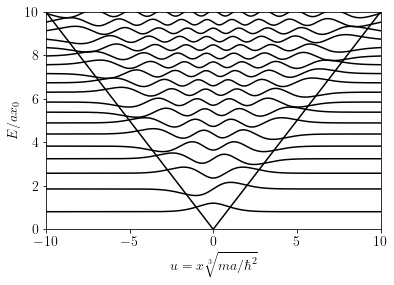

In [9]:
plt.figure()
plt.xlim([-xmax, xmax])
plt.ylim([0, xmax])
plt.xlabel('$u = x\sqrt[3]{ma/\hbar^2}$')
plt.ylabel('$E/ax_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, (-1)**(v+1)*0.5*psi[:,v] + en[v], 'k-')
# plt.savefig('AbsWellwvfcns.svg')
# plt.savefig('SHOwvfcns.svg')

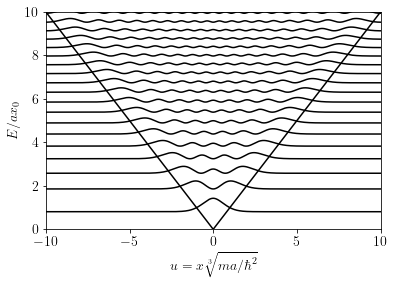

In [10]:
plt.figure()
plt.xlim([-xmax, xmax])
plt.ylim([0, xmax])
plt.xlabel('$u = x\sqrt[3]{ma/\hbar^2}$')
plt.ylabel('$E/ax_0$')
plt.plot(x, Vx, 'k-')
for v in range(len(en)):
    if en[v] < max(Vx):
        plt.plot(x, psi[:,v]*psi[:,v] + en[v], 'k')
# plt.savefig('AbsWellProb.svg')

Below are the percent errors between the calculated and actual energies. Note that the percent errors get above 1% for $n > 17$. This differs from the SHO case due to the fact that the walls of this potential well never change steepness, so the wave functions all taper off to zero at the boundary with similar inflection.

In [11]:
# This is the percent error for each energy for the Airy wave functions

print('n', '\t', '% error', '\n')
for i in range(int(len(en)/2)):
    if en[i] < max(Vx):
        print(2*i, '\t', 100*(en[2*i]/-sp.ai_zeros(len(en))[1][i]*2.**(1/3) - 1))
    if en[i] < max(Vx):
        print(2*i+1, '\t', 100*(en[2*i+1]/-sp.ai_zeros(len(en))[0][i]*2.**(1/3) - 1))

n 	 % error 

0 	 0.0006083177044979848
1 	 -1.6858880957926203e-08
2 	 5.983099424788918e-05
3 	 -2.8272029162224044e-08
4 	 2.7145871683842415e-05
5 	 -4.560222199856412e-08
6 	 1.6571882688332096e-05
7 	 -4.6064663195011235e-08
8 	 1.1823153633905292e-05
9 	 3.078774324372091e-06
10 	 3.66570607424066e-05
11 	 0.00020654031516187388
12 	 0.001232957291197323
13 	 0.00610346038953935
14 	 0.024711083250972266
15 	 0.08341551146739956
16 	 0.23081945763365752
17 	 0.538203087593847
18 	 1.0662040056854893
19 	 1.8606707918690457
20 	 2.9184913913661514
21 	 4.2367142131281454
22 	 5.777925080930357
23 	 7.532132777387579
24 	 9.461854752920672
25 	 11.563162993398567
26 	 13.804863936463963
27 	 16.187812599823648
28 	 18.686533141573115
29 	 21.304301347682085
30 	 24.02025518107578
31 	 26.838564540200483
32 	 29.742120910525326
33 	 32.735128582162076
34 	 35.80359070228993
35 	 38.95128726749073
36 	 42.166838016383835
37 	 45.453370949223235


In [12]:
# The energy eigenvalues are scaled by a factor of 2**(1/3)
# for the absolute value potential compared to the natural
# units usually employed.
en[:10]*2**(1/3)

array([1.01879917, 2.33810741, 3.24819953, 4.08794944, 4.82010052,
       5.52055983, 6.16330838, 6.78670809, 7.37217813, 7.94413383])